In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [129]:
import scipy.linalg as la
import scipy.stats as stats
import scipy.optimize as opt

In [4]:
save_dir = "result_epidemia"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 1. data

In [7]:
data = pd.read_csv('data/EuropeCovid2.csv', index_col=0)

In [366]:
GPi = np.load('data/GPi.npz')

In [8]:
data

,id,country,date,cases,deaths,schools_universities,self_isolating_if_ill,public_events,lockdown,social_distancing_encouraged,pop
1,AT,Austria,2020-01-03,0.0,0.0,0,0,0,0,0,NaN
2,AT,Austria,2020-01-04,0.0,0.0,0,0,0,0,0,NaN
3,AT,Austria,2020-01-05,0.0,0.0,0,0,0,0,0,NaN
4,AT,Austria,2020-01-06,0.0,0.0,0,0,0,0,0,NaN
5,AT,Austria,2020-01-07,0.0,0.0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1976,GB,United_Kingdom,2020-06-26,778.0,99.0,1,1,1,1,1,NaN
1977,GB,United_Kingdom,2020-06-27,721.0,77.0,1,1,1,1,1,NaN
1978,GB,United_Kingdom,2020-06-28,671.0,40.0,1,1,1,1,1,NaN
1979,GB,United_Kingdom,2020-06-29,649.0,31.0,1,1,1,1,1,NaN


In [9]:
regions = np.array(data['id'].unique())
regions = regions[regions != 'SE']

In [10]:
regions

array(['AT', 'BE', 'DK', 'FR', 'DE', 'IT', 'NO', 'ES', 'CH', 'GB'],
      dtype=object)

In [11]:
d = 2

# 2. results

In [12]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(mean, cov, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

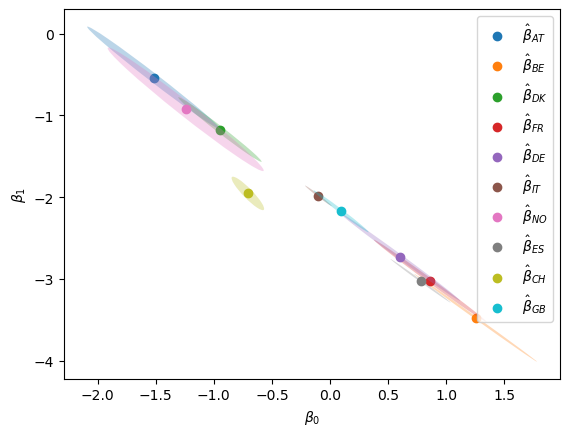

In [13]:
f, ax = plt.subplots(1,1)
for i, r in enumerate(regions):
    locals().update(np.load('%s/results_nbinom_%s.npz'%(save_dir,r)))
    p = ax.scatter(bmle[0], bmle[1], label=r"$\hat{\beta}_{%s}$"%r)
    confidence_ellipse(bmle, np.linalg.pinv(Ihat_dth)[2:,2:], ax, 
                       facecolor=p.get_facecolor(), alpha=0.3)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); plt.legend()

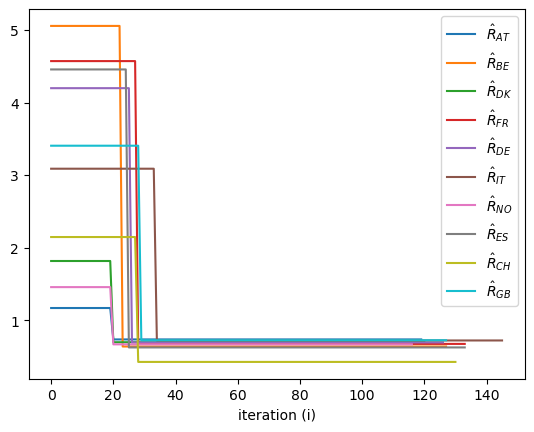

In [15]:
for i, r in enumerate(regions):
    locals().update(np.load('%s/results_nbinom_%s.npz'%(save_dir,r)))
    plt.plot(Rmle, label=r"$\hat{R}_{%s}$"%r)
plt.xlabel("iteration (i)"); plt.legend()

# 3. EBCR

In [31]:
weights = np.zeros([len(regions)])
betas = np.zeros([len(regions), d])
Sigmas = np.zeros([len(regions), d, d])

In [64]:
for i, r in enumerate(regions):
    locals().update(np.load('%s/results_nbinom_%s.npz'%(save_dir,r)))
    betas[i] = bmle
    Sigmas[i] = np.linalg.pinv(Ihat_sdw)[2:,2:]
    weights[i] = 1/np.exp(np.linalg.slogdet(Sigmas[i])[1]/d)

In [65]:
mu = np.sum(weights[:,None] * betas, 0) / np.sum(weights)

In [66]:
eps = betas - mu

In [67]:
Phi = (np.sum(weights[:,None,None] 
              * (eps[:,:,None] * eps[:,None,:] - Sigmas), 0)
       / np.sum(weights)) 

In [69]:
W_eb = np.linalg.inv(np.eye(d) + Sigmas@np.linalg.inv(Phi))

In [70]:
th_eb = mu + (W_eb @ eps[:,:,None])[...,0]

In [91]:
Var_eb = W_eb @ Sigmas @ W_eb.transpose([0,2,1])

In [545]:
alpha = 0.05

In [546]:
chi_pa = np.sqrt(stats.chi2(d).ppf(1-alpha))

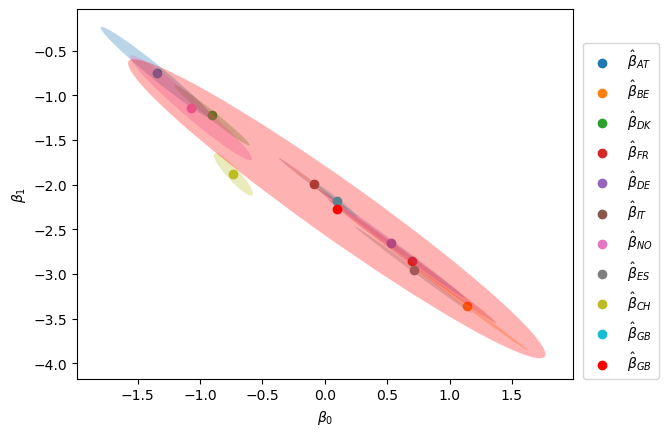

In [555]:
f, ax = plt.subplots(1,1)
for i, r in enumerate(regions):
    p = ax.scatter(th_eb[i,0], th_eb[i,1], label=r"$\hat{\beta}_{%s}$"%r)
    confidence_ellipse(th_eb[i], Var_eb[i], ax, n_std = chi_pa,
                       facecolor=p.get_facecolor(), alpha=0.3)
p = ax.scatter(mu[0], mu[1], color='red', label=r"$\hat{\beta}_{%s}$"%r)
confidence_ellipse(mu, Phi, ax, n_std = chi_pa,
                   facecolor=p.get_facecolor(), alpha=0.3)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); plt.legend(loc=(1.02,0))

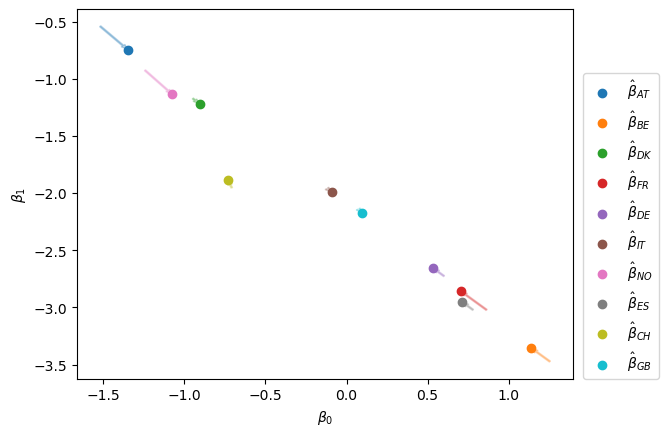

In [567]:
f, ax = plt.subplots(1,1)
for i, r in enumerate(regions):
    p = ax.scatter(*th_eb[i], label=r"$\hat{\beta}_{%s}$"%r)
    ax.arrow(*betas[i], *(th_eb[i]-betas[i]), width=0.01, 
             length_includes_head=True,
             color=p.get_facecolor(), alpha=0.3)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); plt.legend(loc=(1.02,0))

In [72]:
def moments(A, eps, Sig, wgt):
    trAYYt = np.sum(A * eps[:,:,None] * eps[:,None,:], axis=(1,2))
    trAS = np.sum(A * Sig, axis=(1,2))
    
    ASA = A @ Sig @ A
    trASAYYt = np.sum(ASA * eps[:,:,None] * eps[:,None,:], axis=(1,2))
    trASAS = np.sum(ASA * Sig, axis=(1,2))
    
    m2 = max(0, np.sum(wgt * (trAYYt - trAS)) / np.sum(wgt))
    m4 = max(m2**2, np.sum(wgt * ((trAYYt - trAS)**2 + 2*trASAS - 4*trASAYYt)) / np.sum(wgt))
    
    return m2, m4

In [73]:
As = np.linalg.inv(Phi) @ Sigmas @ np.linalg.inv(Phi)

In [138]:
m2 = np.zeros([len(regions)])
m4 = np.zeros([len(regions)])

In [139]:
for i, _ in enumerate(regions):
    m2[i], m4[i] = moments(As[i], eps, Sigmas, weights)

In [344]:
import cv
importlib.reload(cv)

<module 'cv' from '/Users/blueconet/Documents/causepid/cv.py'>

In [345]:
CV_d = cv.CV(d, random_seed = 0)

In [332]:
chi_eb = [CV_d.cva(alpha, m2[i], m4[i])['cv']
          for i, _ in enumerate(regions)]

In [548]:
chi_pa

2.447746830680816

In [534]:
chi_eb

[2.57641179640889,
 2.5123394512929615,
 2.4872207970694826,
 2.626823703380502,
 2.5663151880586517,
 2.466643685109747,
 2.7730041493525976,
 2.5096240502345886,
 2.521442996695539,
 2.4569826018107306]

In [347]:
[CV_d.rho_l(chi_eb[i], m2[i], m4[i])['alpha']
 for i,_ in enumerate(regions)]

[0.050283932232908626,
 0.050200233582837914,
 0.05006077811483591,
 0.05006349875502157,
 0.050319622324513084,
 0.0500797805045271,
 0.049543041349095325,
 0.05018507696750403,
 0.050213468334040764,
 0.050040772215626216]

In [549]:
[CV_d.rho(chi_pa, m2[i], m4[i])['alpha']
 for i,_ in enumerate(regions)]

[0.06689998125031027,
 0.05829090691257988,
 0.05497893536236646,
 0.07384003617158243,
 0.06547199672470423,
 0.05237729489497641,
 0.0966277477040082,
 0.05793683685359031,
 0.05943922695833199,
 0.051165369225027145]

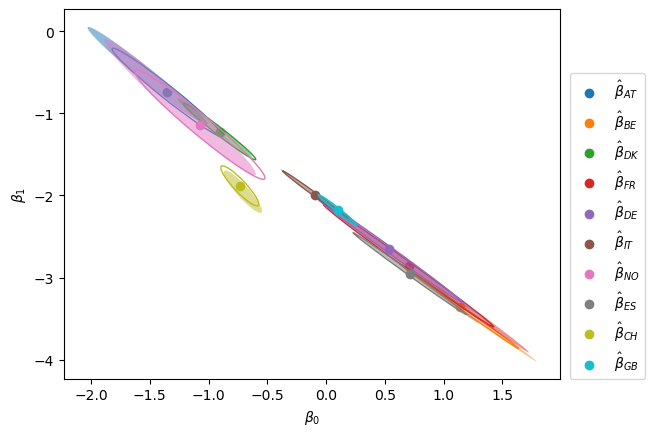

In [590]:
f, ax = plt.subplots(1,1)
for i, r in enumerate(regions):
    p = ax.scatter(th_eb[i,0], th_eb[i,1], label=r"$\hat{\beta}_{%s}$"%r)
    confidence_ellipse(th_eb[i], Var_eb[i], ax, n_std = chi_eb[i],
                       edgecolor=p.get_facecolor(), alpha=1)
    confidence_ellipse(betas[i], Sigmas[i], ax, n_std = chi_pa,
                       facecolor=p.get_facecolor(), alpha=0.5)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); plt.legend(loc=(1.02,0))

# 4. Causal Forecasting

In [591]:
def EY_t(beta, mu_0, A):
    assert A.shape[0] > T0
    
    T = A.shape[0]-T0
    R = np.zeros(T+T0)
    for t in np.arange(T+T0):
        o = np.exp(- beta @ A[t])
        p = 1 / (1 + o)
        R[t] = K * p 
        
    # g
    g = np.zeros(T+T0)
    g[:np.minimum(T+T0,len(GPi['g']))] \
    = GPi['g'][:np.minimum(T+T0,len(GPi['g']))]
    
    # pi
    pi = np.zeros(T+T0)
    pi[:np.minimum(T+T0,len(GPi['pi']))] \
    = GPi['pi'][:np.minimum(T+T0,len(GPi['pi']))]
        
    Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
    G = R[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    
    return mu_0 * np.linalg.inv(np.eye(T+T0)-G)[:,0] @ Pi.T

In [592]:
T0 = 20
alpha = 1
K = 6.5

In [593]:
Tf = 30
Af = np.zeros([Tf, d])

In [594]:
regions

array(['AT', 'BE', 'DK', 'FR', 'DE', 'IT', 'NO', 'ES', 'CH', 'GB'],
      dtype=object)

In [595]:
r = 'GB'
i = int(np.where(regions == r)[0])

In [596]:
regions[i]

'GB'

In [597]:
locals().update(np.load('%s/results_nbinom_%s.npz'%(save_dir,r)))

In [609]:
Af[:,0] = np.full(Tf, 1)
Af[:,1] = np.full(Tf, 0)

In [610]:
Te = T+Tf
Ae = np.concatenate([A, Af], 0)

In [611]:
up = th_eb[i] + chi_eb[i] * np.sqrt(np.diag(Var_eb[i]))
lo = th_eb[i] - chi_eb[i] * np.sqrt(np.diag(Var_eb[i]))

In [612]:
cons = lambda x: chi_eb[i]**2 - (th_eb[i] - x) @ la.inv(Var_eb[i]) @ (th_eb[i] - x)

In [613]:
conf_band = np.zeros([Te, 2])
beta_mm = np.zeros([Te,2,2])

for t in np.arange(Te):
    print(t)
    if t == 0:
        init_min = th_eb[i]
        init_max = th_eb[i]
    else:
        init_min = beta_mm[t-1,0]
        init_max = beta_mm[t-1,1]
        
    result_min = opt.minimize(
        lambda x: EY_t(x, mmle_0, Ae[:T0+t+1])[-1], init_min,
        bounds=np.transpose([lo, up]),
        constraints={'type':'ineq', 'fun': cons}
    )
    result_max = opt.minimize(
        lambda x: -EY_t(x, mmle_0, Ae[:T0+t+1])[-1], init_max,
        bounds=np.transpose([lo, up]),
        constraints={'type':'ineq', 'fun': cons}
    )
    conf_band[t] = np.array([result_min.fun, -result_max.fun])
    beta_mm[t] = np.array([result_min.x, result_max.x])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137


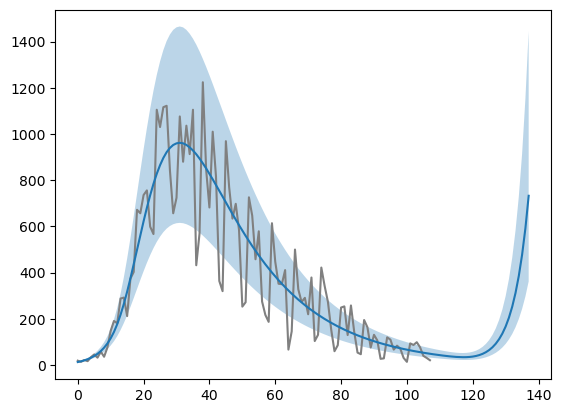

In [614]:
plt.plot(Y, color='grey')
plt.plot(EY_t(th_eb[i], mmle_0, Ae))
plt.fill_between(np.arange(np.shape(conf_band)[0]),
                 conf_band[:,0], conf_band[:,1], alpha=0.3)

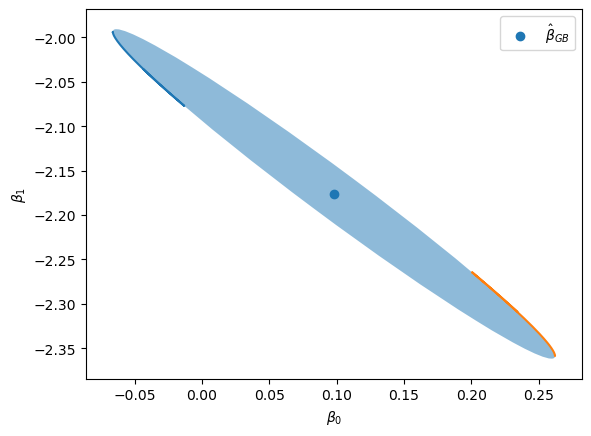

In [615]:
f, ax = plt.subplots(1,1)
p = ax.scatter(th_eb[i,0], th_eb[i,1], label=r"$\hat{\beta}_{%s}$"%r)
confidence_ellipse(th_eb[i], Var_eb[i], ax, n_std = chi_eb[i],
                   facecolor=p.get_facecolor(), alpha=0.5)
plt.plot(beta_mm[:,0,0], beta_mm[:,0,1])
plt.plot(beta_mm[:,1,0], beta_mm[:,1,1])
#     confidence_ellipse(th_eb[i], Sigmas[i], ax, n_std = chi_pa,
#                        facecolor=p.get_facecolor(), alpha=0.25)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); plt.legend()

In [623]:
Af[:,0] = np.full(Tf, 1)
Af[:,1] = np.full(Tf, 0.5)

In [624]:
Te = T+Tf
Ae = np.concatenate([A, Af], 0)

In [625]:
up = th_eb[i] + chi_eb[i] * np.sqrt(np.diag(Var_eb[i]))
lo = th_eb[i] - chi_eb[i] * np.sqrt(np.diag(Var_eb[i]))

In [626]:
cons = lambda x: chi_eb[i]**2 - (th_eb[i] - x) @ la.inv(Var_eb[i]) @ (th_eb[i] - x)

In [627]:
conf_band = np.zeros([Te, 2])
beta_mm = np.zeros([Te,2,2])

for t in np.arange(Te):
    print(t)
    if t == 0:
        init_min = th_eb[i]
        init_max = th_eb[i]
    else:
        init_min = beta_mm[t-1,0]
        init_max = beta_mm[t-1,1]
        
    result_min = opt.minimize(
        lambda x: EY_t(x, mmle_0, Ae[:T0+t+1])[-1], init_min,
        bounds=np.transpose([lo, up]),
        constraints={'type':'ineq', 'fun': cons}
    )
    result_max = opt.minimize(
        lambda x: -EY_t(x, mmle_0, Ae[:T0+t+1])[-1], init_max,
        bounds=np.transpose([lo, up]),
        constraints={'type':'ineq', 'fun': cons}
    )
    conf_band[t] = np.array([result_min.fun, -result_max.fun])
    beta_mm[t] = np.array([result_min.x, result_max.x])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137


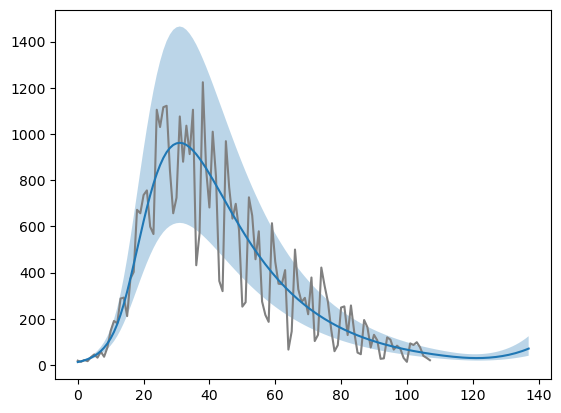

In [628]:
plt.plot(Y, color='grey')
plt.plot(EY_t(th_eb[i], mmle_0, Ae))
plt.fill_between(np.arange(np.shape(conf_band)[0]),
                 conf_band[:,0], conf_band[:,1], alpha=0.3)

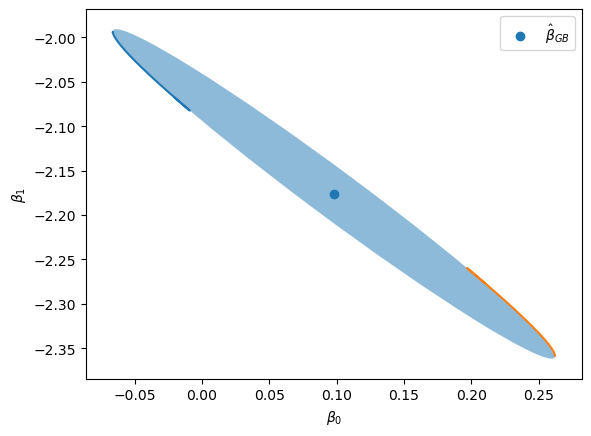

In [629]:
f, ax = plt.subplots(1,1)
p = ax.scatter(th_eb[i,0], th_eb[i,1], label=r"$\hat{\beta}_{%s}$"%r)
confidence_ellipse(th_eb[i], Var_eb[i], ax, n_std = chi_eb[i],
                   facecolor=p.get_facecolor(), alpha=0.5)
plt.plot(beta_mm[:,0,0], beta_mm[:,0,1])
plt.plot(beta_mm[:,1,0], beta_mm[:,1,1])
#     confidence_ellipse(th_eb[i], Sigmas[i], ax, n_std = chi_pa,
#                        facecolor=p.get_facecolor(), alpha=0.25)
plt.xlabel(r"$\beta_0$"); plt.ylabel(r"$\beta_1$"); plt.legend()